In [ ]:
%pip install sdv
%pip install seaborn
%pip install matplotlib

In [1]:
import os
import numpy as np
import pandas as pd

from sdv.metadata import Metadata
from sdv.single_table import GaussianCopulaSynthesizer

- Read a set of anonymized data from the hospital. (Mi. 2023)
- Randomly use 70 percent of that data to train a model for generating synthetic data.

Reference: Mi H. Clinical data for both discovery and validation cohorts. 2023. https://doi.org/10.6084/m9.figshare.22638145.v1

In [2]:
raw = pd.read_csv('./Clinical_Data_Validation_Cohort.csv', encoding="utf-8")
raw = raw.sample(frac=0.7, random_state=42)

Inspect the metadata detacted by the SDV engine. The metadata visualization shows the details of the tables and their relationships in the dataset.

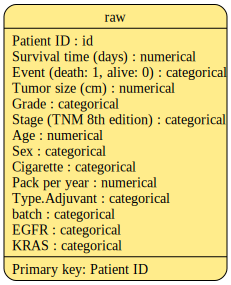

In [3]:
metadata = Metadata.detect_from_dataframes(
    data={'raw': raw}
)

metadata.visualize(
  show_table_details='full',
  show_relationship_labels=True
)

In [4]:
if os.path.exists('raw_metadata.json'):
    os.remove('raw_metadata.json')

metadata.save_to_json(filepath='raw_metadata.json')

If nothing is amiss in the metadata above, then we can proceed to the next step. The next step is to create a synthesizer object. The synthesizer object is used to generate synthetic data based on the metadata and the raw data. We will use the GaussianCopulaSynthesizer, which is a type of synthesizer that uses a Gaussian copula to generate synthetic data. The Gaussian copula is a statistical model that allows us to generate synthetic data that has similar statistical properties to the raw data.

In [5]:
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(raw)
synthetic_raw = synthesizer.sample(num_rows=1000)

Run diagnostic evaluation to assess the quality of the synthetic data compared to the real data using the provided metadata.

In [6]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=raw,
    synthetic_data=synthetic_raw,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 14/14 [00:00<00:00, 1101.51it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 202.10it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

Let's use a boxplot to check out how Age is distributed in both the original and the synthesized data.

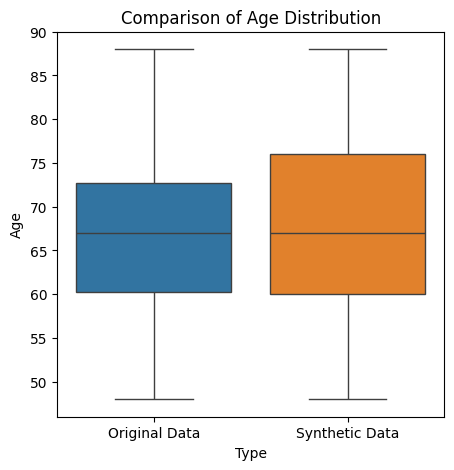

In [8]:
combined_df = pd.DataFrame({
    'Age': pd.concat([raw['Age'], synthetic_raw['Age']]),
    'Type': ['Original Data'] * len(raw) + ['Synthetic Data'] * len(synthetic_raw)
})

plt.figure(figsize=(5, 5))
sns.boxplot(x='Type', y='Age', data=combined_df, hue='Type')
plt.ylabel('Age')
plt.title('Comparison of Age Distribution')
plt.show()

We can also compare them using a histogram. In this plot, you can see the synthetic data is a little more right-skewed.

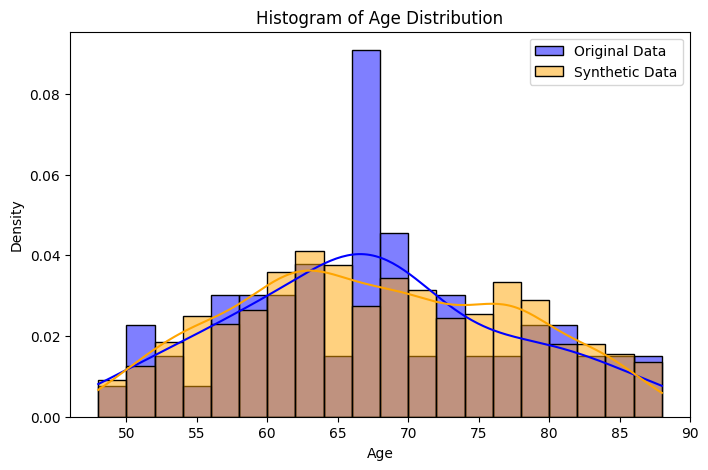

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(raw['Age'], color='blue', label='Original Data', kde=True, stat="density", bins=20)
sns.histplot(synthetic_raw['Age'], color='orange', label='Synthetic Data', kde=True, stat="density", bins=20)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Histogram of Age Distribution')
plt.legend()
plt.show()

In [10]:
def value_frequencies(series1, series2):
	"""
	Compare the value frequencies between two pandas Series.

	This function calculates the frequency and ratio of each unique value in two input Series
	and merges the results into a single DataFrame for comparison. Missing values are filled with 0.

	Parameters:
	- series1 (pd.Series): The first pandas Series (e.g., original data).
	- series2 (pd.Series): The second pandas Series (e.g., synthetic data).

	Returns:
	- pd.DataFrame: A DataFrame containing the value, count, and ratio for both Series.
	"""
	freq1 = series1.value_counts().reset_index()
	freq1.columns = ['Value', 'Original_Count']
	freq1['Original_Ratio'] = (freq1['Original_Count'] / freq1['Original_Count'].sum() * 100).round(2)

	freq2 = series2.value_counts().reset_index()
	freq2.columns = ['Value', 'Synthetic_Count']
	freq2['Synthetic_Ratio'] = (freq2['Synthetic_Count'] / freq2['Synthetic_Count'].sum() * 100).round(2)

	result = pd.merge(freq1, freq2, on='Value', how='outer').fillna(0)
	return result

Now we can see how each category from the original data compares to the one in the synthetic data generated by SDV.

In [11]:
categorical_columns = raw.select_dtypes(include=['object', 'category']).columns.drop('Patient ID')

for column in categorical_columns:
	series1 = raw[column]
	series2 = synthetic_raw[column]
	print(f"Value frequencies for column: {column}")
	display(value_frequencies(series1, series2))

Value frequencies for column: Stage (TNM 8th edition)


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,IA2,13,19.70,184,18.4
1,IA3,12,18.18,173,17.3
2,IB,17,25.76,273,27.3
3,IIA,2,3.03,37,3.7
4,IIB,7,10.61,104,10.4
5,IIIA,11,16.67,163,16.3
6,IIIB,1,1.52,19,1.9
7,Recurrence,3,4.55,47,4.7


Value frequencies for column: Sex


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,Female,44,66.67,552,55.2
1,Male,22,33.33,448,44.8


Value frequencies for column: Cigarette


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,Current,9,13.64,146,14.6
1,Former,43,65.15,645,64.5
2,Never,14,21.21,209,20.9


Value frequencies for column: Type.Adjuvant


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,Chemo,12,80.00,198,79.2
1,Chemorad,2,13.33,43,17.2
2,XRT,1,6.67,9,3.6


Value frequencies for column: EGFR


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,Exon 19,6,10.00,91,10.02
1,Exon 19 (15bp delete),1,1.67,7,0.77
2,Exon 19 (9bp delete),1,1.67,10,1.10
3,Exon 21,2,3.33,35,3.85
4,Exon 21 (L858R),2,3.33,42,4.63
5,Negative,48,80.00,723,79.63


Value frequencies for column: KRAS


,Value,Original_Count,Original_Ratio,Synthetic_Count,Synthetic_Ratio
0,G12C,7,15.22,95,13.97
1,G12D,5,10.87,88,12.94
2,G12F,1,2.17,14,2.06
3,G12R,1,2.17,8,1.18
4,G12V,6,13.04,96,14.12
5,G13C,1,2.17,17,2.50
6,G13F,1,2.17,26,3.82
7,G13R,1,2.17,18,2.65
8,Negative,23,50.00,318,46.76


To simulate a data source using a hierarchical file format, we reorganize the pandas dataframe by grouping smoking-related data under Usage and demographic details like Sex and Age under Demog for each record. Then, we export the transformed data to a line-delimited JSON file. For example:

```json
{
    "Patient ID": "sdv-id-ddBQHW",
    "Survival time (days)": 2215,
    ...
    "Usage": {
        "Cigarette": "Former",
        "Pack per year": 2.75
    },
    "Demog": {
        "Age": 69,
        "Sex": "Female"
    }
}
```

In [12]:
synthetic_raw['Usage'] = synthetic_raw.apply(lambda row: {'Cigarette': row['Cigarette'], 'Pack per year': row['Pack per year']}, axis=1)
synthetic_raw['Demog'] = synthetic_raw[['Age', 'Sex']].to_dict(orient='records')
synthetic_raw.drop(columns=['Age', 'Sex', 'Cigarette', 'Pack per year'], inplace=True)
synthetic_raw.to_json('synthetic_raw.json', orient='records', lines=True)